# Comparaison des prédictions des différentes lignées cellulaires et du modèle estimé par apprentissage de transfert sur certaines séquences de test

In [1]:
import json
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [2]:
import h5py
import cooler

In [3]:
import matplotlib.pyplot as plt

In [4]:
predpath = "/home/bureau/projects/def-bureau/bureau/ran-donnees/PredictNeuronHi-C/akita_pred_test/"
predfile = predpath + "preds.h5"

In [5]:
pred = h5py.File(predfile, 'r')
pred

<HDF5 file "preds.h5" (mode r)>

In [6]:
pred.keys()

<KeysViewHDF5 ['preds']>

In [7]:
pred['preds'].shape

(6667, 99681, 5)

In [11]:
targetfile = "/home/bureau/projects/def-bureau/bureau/distiller/iPSC/data/1m/seqs_cov/0.h5"

In [12]:
targets = h5py.File(targetfile, 'r')
targets

<HDF5 file "0.h5" (mode r)>

In [13]:
# Les données de tests sont les 6667 (pred['preds'].shape[0]) dernières
test_targets = targets['targets'][targets['targets'].shape[0]-pred['preds'].shape[0]:,]

In [14]:
test_targets.shape

(6667, 99681)

In [8]:
predf = h5py.File('pred_final.h5', 'r')
predf

<HDF5 file "pred_final.h5" (mode r)>

In [9]:
predf.keys()

<KeysViewHDF5 ['pred_final']>

In [10]:
predf['pred_final'].shape

(6667, 99681)

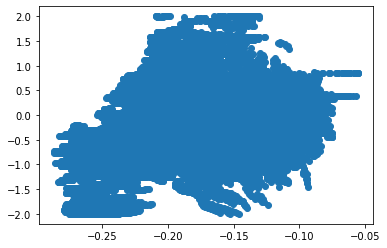

In [16]:
plt.scatter(predf['pred_final'][1,:], test_targets[1,:])
plt.show()

## Examen du 1er point de contact

In [36]:
# Le décalage est de 16
[test_targets[1,16],test_targets[0,13372]]

[-0.1072, -0.1072]

In [38]:
tmp = list(abs(test_targets[0,]-test_targets[1,0])<0.0001)
tmp.index(True)

7362

In [39]:
[test_targets[1,0],test_targets[0,7362]]

[0.3306, 0.3306]